# Making a descriptive statistics table
Prepare dataframes of the case and control group before this analysis

## Preparation 

In [1]:
# Read modules
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# We used R library combined with python.
import rpy2

print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("matplotlib:",mpl.__version__)
print("rpy2:",rpy2.__version__)

%load_ext rpy2.ipython

pandas: 1.3.4
numpy: 1.22.4
matplotlib: 3.6.3
rpy2: 3.5.6


In [2]:
# Set output path
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
output_dir = current_path + 'NephroticSyndrome_checkups/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    

# Data path
personal_path = current_path + "NephroticSyndrome_csv/Personals.csv"
checkup_path = current_path + "NephroticSyndrome_csv/Checkups.csv"
group_label_path = current_path + "NephroticSyndrome_csv/group.csv"



## Descriptive statistics table

In [3]:
# Personal data of both group
use_cols= ['Enrollee ID', 'Sex', 
           'Age_at_start',
           "Death_censor",
           "Obsevation_length",
           "Target_diag_yyyymm",
           "Observation_start_yyyymm",
           "Observation_end_yyyymm",
           'Target']

df_p = pd.read_csv (current_path + 'NephroticSyndrome_csv/'+'patient/Group_diseases.csv',
                   usecols=use_cols).drop_duplicates()
df_c = pd.read_csv (current_path + 'NephroticSyndrome_csv/'+'control/Group_diseases.csv',
                   usecols=use_cols).drop_duplicates()

df_ps = pd.concat([df_p,df_c])
# Translate Japanese column names into English ones
dic_en= {'加入者ID':"Enrollee ID","加入者性別": "Sex","観察終了理由(死亡)フラグ":"Death"}
df_ps.rename(columns=dic_en,inplace=True)

# Translate Japanese categorical variables into English ones
dic_env= {"女性":"Female","男性":"Male"}
df_ps.replace(dic_env,inplace=True)
df_ps.head(2)

,Enrollee ID,Sex,Observation_start_yyyymm,Observation_end_yyyymm,Death_censor,Target_diag_yyyymm,Age_at_start,Obsevation_length,Target
0,M000051963,Female,201101,201903,NaN,201411,36,98,1
329,M000055609,Male,201203,201903,NaN,201504,60,84,1


In [4]:
df_ps["Before_onset"] = - (pd.to_datetime(df_ps["Observation_start_yyyymm"],format="%Y%m").dt.to_period("M").view(int) 
                           - pd.to_datetime(df_ps["Target_diag_yyyymm"],format="%Y%m").dt.to_period("M").view(int)) 
df_ps["After_onset"] = pd.to_datetime(
    df_ps["Observation_end_yyyymm"],format="%Y%m").dt.to_period("M").view(int) - pd.to_datetime(
    df_ps["Target_diag_yyyymm"],format="%Y%m").dt.to_period("M").view(int)

In [5]:
# Our dataframe for English translation of checkup data
df_en = pd.read_csv(current_path + 'HealthCheckupEnglish_for_R_cp932.csv',encoding="cp932")      
dic_en = dict(zip(df_en.Japanese,df_en.Bind))

# Health checkup data of both group
df_hc = pd.read_csv(checkup_path) 
df_hc.rename(columns=dic_en,inplace=True)
df_fhc = df_hc.sort_values(by="Health examination ymd",
                           kind="mergesort").drop_duplicates(subset="Enrollee ID", keep="first")

<BarContainer object of 57 artists>

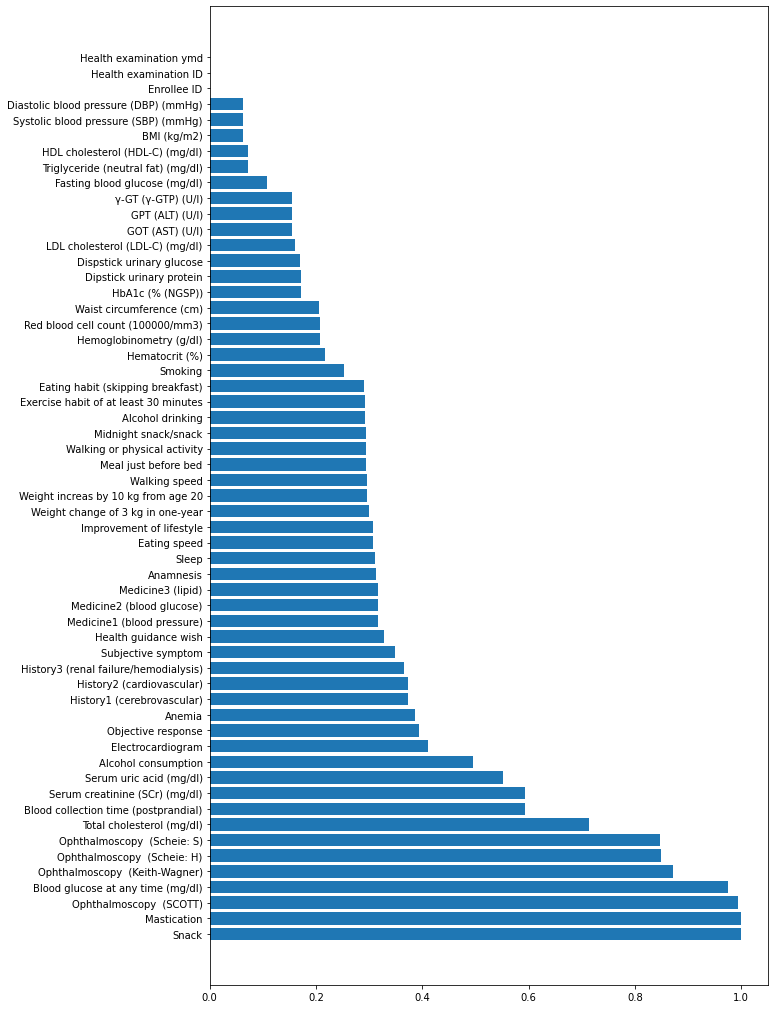

In [6]:
# Check missing value ratio
plt.figure(figsize=(10,18))
df_missing = pd.DataFrame(columns=["Missing"],data=df_fhc.isnull().sum(axis=0)
                         ).sort_values(by="Missing", ascending =False, kind="mergesort")
# Draw missing ratio in barplot
plt.barh(df_missing.index,df_missing.Missing/len(df_fhc))

In [7]:
# We used missing value ratio is less than 20% except additional columns which are closely related to our results
additional = ["Serum uric acid (mg/dl)","Serum creatinine (SCr) (mg/dl)"]
use_cols = df_missing[(df_missing.Missing/822) <0.2].index[::-1].tolist() + additional

In [8]:
# Missing proportion
df_missing.loc[additional]/822

,Missing
Serum uric acid (mg/dl),0.551095
Serum creatinine (SCr) (mg/dl),0.593674


In [9]:
# Concatenate data with sex and death columns
df_fhc = pd.merge(df_ps,df_fhc[use_cols], on = "Enrollee ID")

In [10]:
# We calculated eGFR from serum creatinine using the following formula
"""
eGFR=194×(Age)-0.287 ×(SCr)-1.094 (× 0.739 if Female)
"""
factor_dict = {"Female":0.739,"Male":1}
df_fhc["eGFR"] = df_fhc.apply(
    lambda x: 194*np.power(x["Age_at_start"],-0.287)*np.power(x["Serum creatinine (SCr) (mg/dl)"],-1.094)*factor_dict[x["Sex"]],axis=1)

In [11]:
df_fhc.head(2)

,Enrollee ID,Sex,Observation_start_yyyymm,Observation_end_yyyymm,Death_censor,Target_diag_yyyymm,Age_at_start,Obsevation_length,Target,Before_onset,...,γ-GT (γ-GTP) (U/l),GPT (ALT) (U/l),GOT (AST) (U/l),LDL cholesterol (LDL-C) (mg/dl),Dispstick urinary glucose,Dipstick urinary protein,HbA1c (% (NGSP)),Serum uric acid (mg/dl),Serum creatinine (SCr) (mg/dl),eGFR
0,M000051963,Female,201101,201903,NaN,201411,36,98,1,46,...,18.0,13.0,17.0,116.0,1.0,2.0,5.6,4.1,0.72,73.428659
1,M000055609,Male,201203,201903,NaN,201504,60,84,1,37,...,44.0,20.0,21.0,93.0,1.0,1.0,6.1,NaN,NaN,NaN


## Make table using R gtsummary

In [12]:
%%R
# Read libraries
require(tidyverse)
require(gtsummary)
require(survey)
require(forcats)
require(data.table)
require(flextable)

R[write to console]:  要求されたパッケージ tidyverse をロード中です 



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]:  要求されたパッケージ gtsummary をロード中です 

R[write to console]:  要求されたパッケージ survey をロード中です 

R[write to console]:  要求されたパッケージ grid をロード中です 

R[write to console]:  要求されたパッケージ Matrix をロード中です 

R[write to console]: 
 次のパッケージを付け加えます: ‘Matrix’ 


R[write to console]:  以下のオブジェクトは ‘package:tidyr’ からマスクされています: 

     expand, pack, unpack 


R[write to console]:  要求されたパッケージ survival をロード中です 

R[write to console]: 
 次のパッケージを付け加えます: ‘survey’ 


R[write to console]:  以下のオブジェクトは ‘package:graphics’ からマスクされています: 

     dotchart 


R[write to console]:  要求されたパッケージ data.table をロード中です 

R[write to console]: data.table 1.14.8 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: **********
This installation of data.table has not detected OpenMP support. It should still work but in single-threaded mode.
This is a Mac. Please read https://mac.r-project.org/openmp/. Please engage with Apple and ask them for support. Check r-datatable.com for updates, and our Mac 

In [13]:
%%R  

# Show as a compact style
theme_gtsummary_compact()
theme_gtsummary_journal(journal=c("lancet"),set_theme=TRUE)

# If the distribution looks skewed, summarize it into median[IQR].
nonpara <- c('Triglyceride (neutral fat) (mg/dl)', 
             'GOT (AST) (U/l)','GPT (ALT) (U/l)',
             'γ-GT (γ-GTP) (U/l)', 
             'Fasting blood glucose (mg/dl)',
             'HbA1c (% (NGSP))',"Obsevation_length",
             "Before_onset","After_onset") 

Setting theme `Compact`
Setting theme `The Lancet`


In [14]:
%%R -i df_fhc,df_en
# Factorize category variable avoiding duplicated missing value
is_categorical <- function(x) {
  x %>% 
  as.character() %>% 
  unique() %>% 
  length() <= 10 
    # Recognize variables as a categorical value, if it have lower than 11 unieque variable 
}

# Factorize category variable
df_fhc = df_fhc%>%mutate_if(is_categorical,as.factor)


# Describe levels of factorized variable
for(col in df_en$Bind){
    if(col %in% names(df_fhc)){
        if(is_categorical(df_fhc[[col]])){
            # Number of category
            num = df_en%>%filter(Bind==col)%>%pull(Categories) 
            # Level of the cateogry
            sel = seq(num) %>% sapply(.,as.character) 
            new_level= df_en %>% 
                filter(Bind==col) %>% 
                select(all_of(sel)) %>% 
                t() %>% 
                append(.,"Missing")
            old_level=levels(df_fhc[[col]])
            # Dataframe to change level names
            level_df = data.frame(old_level = old_level,new_level = new_level)
            levels(df_fhc[[col]]) <- level_df$new_level[match(levels(df_fhc[[col]]), level_df$old_level)]
        }
    }
}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "Unit". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "Classification_description_in_Japanese". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '
/Library/Frameworks/Python.f

In [15]:
%%R
# Write table
baseline <- df_fhc %>%  
    # Exclude variables that seem irrelevant
    select(-c('Enrollee ID', 'Health examination ymd','Health examination ID',"Observation_start_yyyymm","Observation_end_yyyymm","Target_diag_yyyymm")) %>% 
    # Recognize variables as a categorical value, 
    # if it have lower than 11 unieque variable (Default)
    mutate(Target = factor(Target, labels = c("Control","Case")))
baseline%>%
    gtsummary::tbl_summary(
        by = "Target", 
        label=list("Diastolic blood pressure (DBP) (mmHg)"~"DBP (mmHg)",
                   "Systolic blood pressure (SBP) (mmHg)"~"SBP (mmHg)",
                   "HDL cholesterol (HDL-C) (mg/dl)" ~ "HDL-C (mg/dl)",
                   "LDL cholesterol (LDL-C) (mg/dl)" ~  "LDL-C (mg/dl)",
                   "Serum uric acid (mg/dl)" ~ "sUA (mg/dl)",
                    "Serum creatinine (SCr) (mg/dl)" ~ "SCr (mg/dl)",
                   "eGFR" ~ "eGFR (ml/min/1.73m2)"
                  ),
        missing = "ifany", 
        missing_text = "Missing",
        type = list(all_continuous()~"continuous",
                    all_categorical()~"categorical",all_of(nonpara) ~"continuous"
                 ),
        statistic = list(all_continuous() ~ "{mean} ± {sd}",
                         all_categorical() ~ "{n} ({p}%)",
                         all_of(nonpara) ~ "{median} ({p25}, {p75})"
                       ),
        digits = list(all_continuous() ~ 1)
    ) %>%
   add_p(pvalue_fun = ~style_pvalue(.x, digits = 3)) %>%
   modify_header(
       label = '',
       stat_1 = 'Control (N=411)',
       stat_2 = 'NS (N=411)',
       p.value = 'p-value') %>%
   as_flex_table() %>% 
   save_as_docx(path = "./NephroticSyndrome_csv/Checukup_statistics_table.docx")

The footnotes, font styles, some items were modified after output. Remove death's missing because it does not mean a missing value.